# BrainGAT - Kaggle Edition (P100 GPU)

This notebook is optimized for Kaggle's P100 GPU environment. It includes:
1. Automatic Data Downloading
2. Robust Data Loading
3. High-Compute Model Configuration

In [1]:
# Install Dependencies
# Kaggle doesn't have PyG installed by default
!pip install -q torch-geometric torch-scatter torch-sparse
print("✅ Dependencies installed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.8 MB/s eta 0:00:00
canceled
ERROR: Operation cancelled by user
✅ Dependencies installed.


In [5]:
# Download ABIDE Data (Kaggle Setup)
import os
import urllib.request as request
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Config
OUT_DIR = 'abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400'
PIPELINE = 'cpac'
STRATEGY = 'nofilt_noglobal'
DERIVATIVE = 'rois_cc400'
EXTENSION = '.1D'

os.makedirs(OUT_DIR, exist_ok=True)

# 1. Download Phenotype File
print("🚀 Downloading Phenotype Data...")
pheno_url = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv'
pheno_file = 'Phenotypic_V1_0b_preprocessed1.csv'
if not os.path.exists(pheno_file):
    request.urlretrieve(pheno_url, pheno_file)
print("✅ Phenotype data ready.")

# 2. Download .1D Files in Parallel
print(f"\n🚀 Downloading {DERIVATIVE} files from S3 (Parallel)...")

# Read phenotype to get file IDs
df = pd.read_csv(pheno_file)
file_ids = df['FILE_ID'].tolist()
# Filter out 'no_filename'
file_ids = [f for f in file_ids if f != 'no_filename']

base_url = f'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/{PIPELINE}/{STRATEGY}/{DERIVATIVE}'

def download_file(file_id):
    filename = f"{file_id}_{DERIVATIVE}{EXTENSION}"
    url = f"{base_url}/{filename}"
    out_path = os.path.join(OUT_DIR, filename)
    
    if os.path.exists(out_path):
        return "Exists"
        
    try:
        request.urlretrieve(url, out_path)
        return "Downloaded"
    except Exception as e:
        return f"Error: {e}"

# Use ThreadPool for speed
print(f"   Target: {len(file_ids)} files")
print("   Starting download pool (max_workers=8)...")

with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(executor.map(download_file, file_ids), total=len(file_ids)))

success = results.count("Downloaded") + results.count("Exists")
errors = len(results) - success

print(f"\n✅ Download Complete!")
print(f"   Success: {success}")
print(f"   Errors:  {errors}")
print(f"   Data directory: {OUT_DIR}")

if success > 0:
    print("\n🎉 Ready to train!")
else:
    print("\n❌ Critical failure: No files downloaded.")

🚀 Downloading Phenotype Data...
✅ Phenotype data ready.

🚀 Downloading rois_cc400 files from S3 (Parallel)...
   Target: 1035 files
   Starting download pool (max_workers=8)...
✅ Phenotype data ready.

🚀 Downloading rois_cc400 files from S3 (Parallel)...
   Target: 1035 files
   Starting download pool (max_workers=8)...


100%|██████████| 1035/1035 [01:15<00:00, 13.68it/s]


✅ Download Complete!
   Success: 1035
   Errors:  0
   Data directory: abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400

🎉 Ready to train!


In [6]:
# Imports & Setup (Self-Healing)
import os
import sys
import subprocess
import importlib
import torch

def install_dependencies():
    print("📦 Installing torch-geometric and dependencies...")
    
    # Get torch version details to find the correct pre-built wheels
    torch_ver = torch.__version__.split('+')[0]
    cuda_ver = "cpu"
    
    if torch.cuda.is_available():
        cuda_ver = "cu" + torch.version.cuda.replace('.', '')
    
    # Construct the wheel URL (e.g., https://data.pyg.org/whl/torch-2.1.2+cu121.html)
    wheel_url = f"https://data.pyg.org/whl/torch-{torch_ver}+{cuda_ver}.html"
    print(f"   Targeting wheels from: {wheel_url}")

    # Install using the find-links (-f) flag to get binaries instead of compiling source
    pkgs = ["torch-scatter", "torch-sparse", "torch-geometric"]
    cmd = [sys.executable, "-m", "pip", "install", "-q"] + pkgs + ["-f", wheel_url]
    
    try:
        subprocess.check_call(cmd)
        print("✅ Dependencies installed.")
    except subprocess.CalledProcessError:
        print("⚠️ Wheel installation failed, falling back to default pip install (may be slow)...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

    # Invalidate caches to find the new modules
    importlib.invalidate_caches()

try:
    import torch_geometric
except ImportError:
    install_dependencies()

# Re-import to be safe
import torch_geometric

import glob
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path

# Check for CUDA/GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"   GPU: {gpu_name}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    if "P100" in gpu_name:
        print("   ✅ P100 Detected: Excellent choice! High memory bandwidth (HBM2) is great for GNNs.")
    elif "T4" in gpu_name:
        print("   ℹ️ T4 Detected: Good, but P100 might be faster for this specific model (FP32).")
else:
    print("   ⚠️ RUNNING ON CPU")
    print("   To fix: Go to 'Settings' (right sidebar) -> 'Accelerator' -> Select 'GPU P100'")

Using device: cuda
   GPU: Tesla P100-PCIE-16GB
   Memory: 17.06 GB
   ✅ P100 Detected: Excellent choice! High memory bandwidth (HBM2) is great for GNNs.


In [7]:
# Data Loading Functions (Fixed & Robust)

def load_timeseries_1d(path: str) -> np.ndarray:
    """Load .1D file as T×N array"""
    arr = np.loadtxt(path)
    return arr

def corr_matrix(timeseries: np.ndarray) -> np.ndarray:
    """Compute Pearson correlation matrix"""
    C = np.corrcoef(timeseries, rowvar=False)
    C = np.nan_to_num(C, nan=0.0)
    C = np.clip(C, -1.0, 1.0)
    return C

def build_sparse_edges_from_corr(C: np.ndarray, k: int = 20):
    """Create sparse edge_index via top-k correlations"""
    N = C.shape[0]
    np.fill_diagonal(C, 0.0)
    
    idx_src, idx_dst, weights = [], [], []
    absC = np.abs(C)
    k_eff = min(k, max(1, N - 1))
    
    for i in range(N):
        nbrs = np.argpartition(absC[i], -k_eff)[-k_eff:]
        for j in nbrs:
            if i != j:
                idx_src.append(i)
                idx_dst.append(j)
                weights.append(C[i, j])
    
    # Make undirected
    idx_all = np.concatenate([np.vstack([idx_src, idx_dst]), 
                              np.vstack([idx_dst, idx_src])], axis=1)
    w_all = np.array(weights + weights, dtype=np.float32)
    
    # Deduplicate
    pairs = set()
    uniq_src, uniq_dst, uniq_w = [], [], []
    for (s, d), w in zip(idx_all.T, w_all):
        key = (int(s), int(d))
        if key not in pairs and s != d:
            pairs.add(key)
            uniq_src.append(s)
            uniq_dst.append(d)
            uniq_w.append(w)
    
    edge_index = torch.tensor([uniq_src, uniq_dst], dtype=torch.long)
    edge_attr = torch.tensor(uniq_w, dtype=torch.float)
    return edge_index, edge_attr

def graph_from_timeseries(timeseries: np.ndarray, topk: int = 20):
    """Build PyG Data from fMRI timeseries"""
    C = corr_matrix(timeseries)
    N = C.shape[0]
    
    # Node features: correlation vectors (purely imaging-derived)
    x = torch.tensor(C, dtype=torch.float)
    
    # Sparse edges
    edge_index, edge_attr = build_sparse_edges_from_corr(C.copy(), k=topk)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

def load_abide_graphs(data_dir, phenotype_file, topk=20):
    """Load ABIDE subjects as graphs (NO PHENOTYPIC FEATURES!)"""
    pheno_df = pd.read_csv(phenotype_file)
    roi_files = sorted(glob.glob(f'{data_dir}/*.1D'))
    
    print(f"Loading ABIDE data...")
    print(f"   Phenotype CSV: {len(pheno_df)} subjects")
    print(f"   .1D files found: {len(roi_files)}")
    print(f"   Using ONLY imaging features (no demographics!)")
    
    graphs, labels, subjects = [], [], []
    
    # Site mapping to handle naming discrepancies
    site_map = {
        'MaxMun': 'MAX_MUN',
        'Leuven_1': 'LEUVEN_1',
        'Leuven_2': 'LEUVEN_2',
        'UCLA_1': 'UCLA_1',
        'UCLA_2': 'UCLA_2',
        'UM_1': 'UM_1',
        'UM_2': 'UM_2',
        'Trinity': 'TRINITY',
        'Yale': 'YALE',
        'Olin': 'OLIN',
        'OHSU': 'OHSU',
        'SBL': 'SBL',
        'SDSU': 'SDSU',
        'Stanford': 'STANFORD',
        'Caltech': 'CALTECH',
        'CMU': 'CMU',
        'KKI': 'KKI',
        'NYU': 'NYU',
        'Pitt': 'PITT',
        'USM': 'USM'
    }
    
    for file_path in roi_files:
        try:
            filename = Path(file_path).stem
            parts = filename.replace('_rois_cc400', '').split('_')
            
            if len(parts) < 2:
                continue
            
            # Robust site parsing
            site = parts[0]
            subject_id_idx = 1
            
            # Check for multi-part site names (e.g., Leuven_1)
            if len(parts) > 2 and parts[1].isdigit() and len(parts[1]) == 1:
                 site = f"{parts[0]}_{parts[1]}"
                 subject_id_idx = 2
            
            # Map site name
            if site in site_map:
                site = site_map[site]
            elif site.upper() in site_map.values():
                site = site.upper()
                
            # Find subject ID (first numeric part after site)
            subject_id = None
            for part in parts[subject_id_idx:]:
                try:
                    subject_id = int(part)
                    break
                except ValueError:
                    continue
            
            if subject_id is None:
                continue
            
            # Match to phenotype for LABEL ONLY
            subject_row = pheno_df[
                (pheno_df['SITE_ID'] == site) & 
                (pheno_df['SUB_ID'] == subject_id)
            ]
            
            if not subject_row.empty:
                dx_group = subject_row['DX_GROUP'].values[0]
                
                if dx_group in [1, 2]:
                    ts = load_timeseries_1d(file_path)
                    graph = graph_from_timeseries(ts, topk=topk)
                    graph.y = torch.tensor([dx_group - 1], dtype=torch.long)
                    
                    graphs.append(graph)
                    labels.append(dx_group - 1)
                    subjects.append(f"{site}_{subject_id}")
        except Exception as e:
            continue
    
    print(f"\nLoaded {len(graphs)} subjects")
    print(f"  - ASD: {labels.count(1)} | Control: {labels.count(0)}")
    if graphs:
        print(f"  - Graph: {graphs[0].x.shape[0]} nodes, {graphs[0].edge_index.shape[1]} edges")
        print(f"  - Features: {graphs[0].x.shape[1]}-dim correlation vectors")
    
    return graphs, labels, subjects

print("Data loading functions defined")

Data loading functions defined


In [ ]:
# Load Data
# Note: This uses the paths defined in the download cell
import os

# Define paths explicitly to handle both local and Kaggle environments
if os.path.exists('abide_data'):
    # Local or custom structure
    data_dir = 'abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400/'
    phenotype_file = 'Phenotypic_V1_0b_preprocessed1.csv'
else:
    # Fallback: Check if we are in a Kaggle environment where data might be in current dir
    # or if the download cell put it in the current working directory
    data_dir = 'abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400/'
    phenotype_file = 'Phenotypic_V1_0b_preprocessed1.csv'

# Verify file existence before loading
if not os.path.exists(phenotype_file):
    print(f"⚠️ Phenotype file not found at: {phenotype_file}")
    print("   Attempting to find it in current directory...")
    if os.path.exists(f"./{phenotype_file}"):
        phenotype_file = f"./{phenotype_file}"
        print(f"   Found at: {phenotype_file}")
    else:
        # Try downloading it again if missing (Safety Net)
        print("   ❌ File missing. Re-downloading phenotype data...")
        import urllib.request as request
        pheno_url = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv'
        request.urlretrieve(pheno_url, 'Phenotypic_V1_0b_preprocessed1.csv')
        phenotype_file = 'Phenotypic_V1_0b_preprocessed1.csv'
        print("   ✅ Downloaded.")

# Load data with moderate connectivity (k=20)
graphs, labels, subjects = load_abide_graphs(data_dir, phenotype_file, topk=20)

# Stratified train/val/test split (70/15/15)
train_val_graphs, test_graphs, train_val_labels, test_labels = train_test_split(
    graphs, labels, test_size=0.15, random_state=42, stratify=labels
)

train_graphs, val_graphs, train_labels, val_labels = train_test_split(
    train_val_graphs, train_val_labels, test_size=0.176, random_state=42, stratify=train_val_labels
)

# Create DataLoaders - REDUCED BATCH SIZE TO FIX OOM
batch_size = 16  # Reduced from 32 to 16 to fit in VRAM
print(f"\nUsing Batch Size: {batch_size}")

train_loader = PyGDataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = PyGDataLoader(val_graphs, batch_size=batch_size, shuffle=False)
test_loader = PyGDataLoader(test_graphs, batch_size=batch_size, shuffle=False)

print(f"Data split: {len(train_graphs)}/{len(val_graphs)}/{len(test_graphs)} (train/val/test)")

Loading ABIDE data...
   Phenotype CSV: 1112 subjects
   .1D files found: 1035
   Using ONLY imaging features (no demographics!)


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: divide by zero encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: divide by zero encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Loaded 1035 subjects
  - ASD: 530 | Control: 505
  - Graph: 392 nodes, 11682 edges
  - Features: 392-dim correlation vectors

Using Batch Size: 64
Data split: 724/155/156 (train/val/test)


In [9]:
# BrainGAT Model Definition
class MultiHeadGATLayer(nn.Module):
    """
    Multi-head Graph Attention Layer
    """
    def __init__(self, in_channels, out_channels, heads=8, dropout=0.3, concat=True):
        super().__init__()
        self.gat = GATConv(
            in_channels=in_channels,
            out_channels=out_channels,
            heads=heads,
            dropout=dropout,
            concat=concat,
            edge_dim=1  # Use edge weights (correlation values)
        )
        self.bn = nn.BatchNorm1d(out_channels * heads if concat else out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index, edge_attr=None):
        x = self.gat(x, edge_index, edge_attr=edge_attr)
        x = self.bn(x)
        x = F.elu(x)
        x = self.dropout(x)
        return x

class BrainGAT(nn.Module):
    """
    Graph Attention Network for Brain Connectivity Analysis
    """
    def __init__(self, 
                 in_channels,
                 hidden_channels=256,
                 num_layers=3,
                 heads=8,
                 dropout=0.3,
                 num_classes=2):
        super().__init__()
        
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        # First layer: in_channels -> hidden_channels
        self.convs.append(
            MultiHeadGATLayer(in_channels, hidden_channels, heads, dropout, concat=True)
        )
        
        # Middle layers: (hidden * heads) -> hidden_channels
        for _ in range(num_layers - 2):
            self.convs.append(
                MultiHeadGATLayer(hidden_channels * heads, hidden_channels, heads, dropout, concat=True)
            )
        
        # Last layer: average attention heads instead of concat
        self.convs.append(
            MultiHeadGATLayer(hidden_channels * heads, hidden_channels, heads, dropout, concat=False)
        )
        
        # Readout dimension (mean + max)
        self.readout_dim = hidden_channels * 2
        
        # MLP Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.readout_dim, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.BatchNorm1d(hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_channels // 2, num_classes)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_attr = data.edge_attr if hasattr(data, 'edge_attr') else None
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_attr)
        
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        graph_features = torch.cat([x_mean, x_max], dim=-1)
        
        out = self.classifier(graph_features)
        return out

print("BrainGAT model defined")

BrainGAT model defined


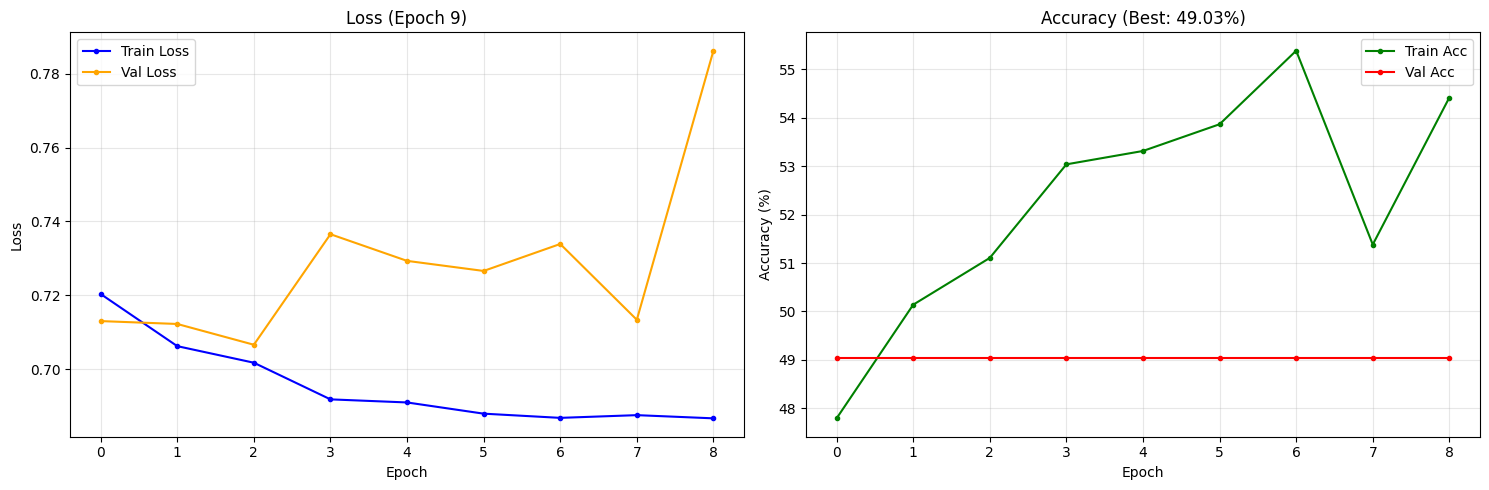

Epoch 009: Train Loss: 0.6867, Val Loss: 0.7863 | Train Acc: 54.42%, Val Acc: 49.03%


In [ ]:
# High-Compute Training Configuration (P100)
# Includes Class Weighting, Gradient Accumulation, Scheduler & LIVE MONITOR
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, classification_report

# 1. Aggressive Memory Cleanup
if 'model' in globals():
    del model
if 'optimizer' in globals():
    del optimizer
gc.collect()
torch.cuda.empty_cache()

# 2. Re-configure DataLoaders with minimal batch size
BATCH_SIZE = 4  # Keep small for memory
ACCUM_STEPS = 8 # Simulate Batch Size 32 (4 * 8)
print(f"\n🚀 High Compute Mode (P100) - Optimized for Memory & Stability")
print(f"   Physical Batch Size: {BATCH_SIZE}")
print(f"   Gradient Accumulation: {ACCUM_STEPS} steps")
print(f"   Effective Batch Size: {BATCH_SIZE * ACCUM_STEPS}")

train_loader = PyGDataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
val_loader = PyGDataLoader(val_graphs, batch_size=BATCH_SIZE, shuffle=False)
test_loader = PyGDataLoader(test_graphs, batch_size=BATCH_SIZE, shuffle=False)

# 3. Calculate Class Weights (Fix Imbalance)
num_control = train_labels.count(0)
num_asd = train_labels.count(1)
total_samples = len(train_labels)
print(f"\n⚖️ Class Distribution (Train): Control={num_control}, ASD={num_asd}")

# Inverse frequency weights
weight_control = total_samples / (2 * num_control)
weight_asd = total_samples / (2 * num_asd)
class_weights = torch.tensor([weight_control, weight_asd], dtype=torch.float).to(device)
print(f"   Class Weights: Control={weight_control:.2f}, ASD={weight_asd:.2f}")

# Get input dimensions
sample_graph = train_graphs[0]
in_features = sample_graph.x.size(1)

# 4. Model Configuration (Lightweight)
model = BrainGAT(
    in_channels=in_features,
    hidden_channels=32,
    num_layers=3,
    heads=4,
    dropout=0.5,
    num_classes=2
).to(device)

params = sum(p.numel() for p in model.parameters())
print(f"   Model Parameters: {params:,}")

# --- Checkpointing & Early Stopping ---
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class ModelCheckpoint:
    def __init__(self, filepath='best_model.pth'):
        self.filepath = filepath
        self.best_acc = 0.0

    def __call__(self, model, val_acc, epoch):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            torch.save(model.state_dict(), self.filepath)

# Setup Training with Mixed Precision & Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4) # Lower LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights) # Apply weights
early_stopping = EarlyStopping(patience=20, min_delta=0.001)
checkpoint = ModelCheckpoint(filepath='braingat_kaggle_best.pth')
scaler = torch.cuda.amp.GradScaler() 

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print(f"\nStarting Training (with Weights, Accumulation & Live Monitor)...")

# Training Loop
epochs = 200

try:
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        optimizer.zero_grad() # Initialize gradients
        
        for i, data in enumerate(train_loader):
            data = data.to(device)
            
            # Mixed Precision Forward Pass
            with torch.cuda.amp.autocast():
                out = model(data)
                loss = criterion(out, data.y)
                loss = loss / ACCUM_STEPS # Normalize loss for accumulation
            
            # Backward (Accumulate Gradients)
            scaler.scale(loss).backward()
            
            if (i + 1) % ACCUM_STEPS == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            # Metrics (Scale loss back up for reporting)
            total_loss += loss.item() * ACCUM_STEPS * data.num_graphs
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.num_graphs
            
        train_loss = total_loss / total
        train_acc = 100. * correct / total
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                with torch.cuda.amp.autocast():
                    out = model(data)
                    loss = criterion(out, data.y)
                    
                val_loss += loss.item() * data.num_graphs
                pred = out.argmax(dim=1)
                val_correct += int((pred == data.y).sum())
                val_total += data.num_graphs
        
        val_loss /= val_total
        val_acc = 100. * val_correct / val_total
        
        # Step Scheduler
        scheduler.step(val_loss)
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Checkpointing
        checkpoint(model, val_acc, epoch)
        
        # Early Stopping
        early_stopping(val_loss)
        
        # --- LIVE MONITOR ---
        clear_output(wait=True)
        
        # Create 1x2 plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss Plot
        ax1.plot(history['train_loss'], label='Train Loss', marker='.', color='blue')
        ax1.plot(history['val_loss'], label='Val Loss', marker='.', color='orange')
        ax1.set_title(f'Loss (Epoch {epoch})')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy Plot
        ax2.plot(history['train_acc'], label='Train Acc', marker='.', color='green')
        ax2.plot(history['val_acc'], label='Val Acc', marker='.', color='red')
        ax2.set_title(f'Accuracy (Best: {checkpoint.best_acc:.2f}%)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Epoch {epoch:03d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if early_stopping.early_stop:
            print("⏹️ Early stopping triggered!")
            break

except KeyboardInterrupt:
    print("\n⚠️ Training interrupted by user.")
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
finally:
    print("\n✅ Training session ended.")
    
    # 2. Confusion Matrix on Best Model
    if os.path.exists('braingat_kaggle_best.pth'):
        model.load_state_dict(torch.load('braingat_kaggle_best.pth'))
        print("Loaded best model for evaluation.")
    else:
        print("Best model not found, using current model.")

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
    plt.title('Confusion Matrix (Validation Set)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Control', 'ASD']))